In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Support Vector Machines library
from sklearn import svm

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

In [2]:
df = pd.read_csv("../processed-datasets/data_outliers_handled_knn_imputed.csv")

In [3]:
df.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.050,10.500,0.050,4.25000,11.60000,1.99000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2737.00000,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,1.555,61.505,0.725,7.74125,12.56125,2.64375,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.020,25.100,0.300,4.41000,12.56125,2.30000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.280,12.000,0.070,1.88000,5.08000,1.01000,...,194.00000,83.0000,356.00000,89.5000,762.000,144.00000,1832.00000,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.070,16.500,0.150,2.32000,8.23000,1.52000,...,257.00000,106.1375,437.54375,97.8675,936.000,171.00000,2355.00000,12535.0,348.0,155.0


In [4]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
# X: Input Features

X = df.drop(['Feature'], axis=1).values

# Output Feature
y = df.Feature.values.astype(int)

### Splitting the dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Scaling the data using Standard Scaler

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fitting the base model of SVM

In [8]:
svm_base = svm.SVC()

In [9]:
svm_base.fit(X_train_scaled, y_train)

SVC()

In [10]:
y_pred = svm_base.predict(X_test_scaled)

In [11]:
print("Accuracy of the base SVM model: ", round(accuracy_score(y_test, y_pred), 3))

Accuracy of the base SVM model:  0.926


In [12]:
print("Classification report of the base model: \n\n", classification_report(y_test, y_pred))

Classification report of the base model: 

               precision    recall  f1-score   support

           0       0.96      0.91      0.93       338
           1       0.89      0.95      0.92       260

    accuracy                           0.93       598
   macro avg       0.92      0.93      0.93       598
weighted avg       0.93      0.93      0.93       598



### Plotting the Confusion Matrix

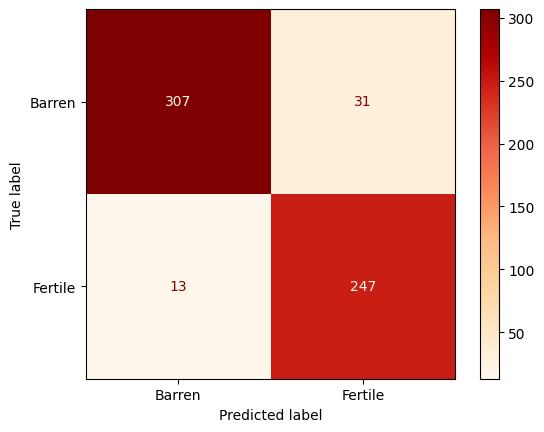

In [13]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot(cmap = 'OrRd')

### Hyper-Parameter Tuning

In [14]:
param_grid = {
    'C': np.arange(0, 5, 1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5, 6],
    'gamma': ['scale', 'auto']
}

In [15]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
clf = GridSearchCV(estimator = svm.SVC(), 
                   param_grid=param_grid, 
                   scoring='accuracy',
                   n_jobs=-1,
                   cv = Stratified_kf, 
                   return_train_score=True, 
                   verbose=2)
#                    refit=False)

In [17]:
clf.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
320 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.9/site-

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0, 1, 2, 3, 4]), 'degree': [3, 4, 5, 6],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=2)

In [18]:
# print("Mean Validation Accuracy: ", np.round(np.nanmean(clf.cv_results_['mean_train_accuracy']), 3))
# print("Mean Validation Precision: ", np.round(np.nanmean(clf.cv_results_['mean_train_precision']), 3))
# print("Mean Validation Recall: ", np.round(np.nanmean(clf.cv_results_['mean_train_recall']), 3))
# print("Mean Validation F1: ", np.round(np.nanmean(clf.cv_results_['mean_train_f1']), 3))

clf.best_score_

0.9397489539748956

In [19]:
clf.best_params_

{'C': 4, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [20]:
print("Best validation accuracy obtained: ", round(clf.best_score_, 3))

Best validation accuracy obtained:  0.94


### Predicting the test set outcomes over best parameters

In [21]:
best_model_gridsearch = svm.SVC(**clf.best_params_)

In [22]:
best_model_gridsearch.fit(X_train_scaled, y_train)

SVC(C=4)

In [23]:
y_pred_best = best_model_gridsearch.predict(X_test_scaled)

In [24]:
print("Accuracy of the test set on tuned model: ", round(accuracy_score(y_test, y_pred_best), 3))

Accuracy of the test set on tuned model:  0.936


In [25]:
print("Classification report of test set on the tuned model: \n\n", classification_report(y_test, y_pred_best))

Classification report of test set on the tuned model: 

               precision    recall  f1-score   support

           0       0.97      0.91      0.94       338
           1       0.89      0.97      0.93       260

    accuracy                           0.94       598
   macro avg       0.93      0.94      0.94       598
weighted avg       0.94      0.94      0.94       598



### Plotting the Confusion Matrix

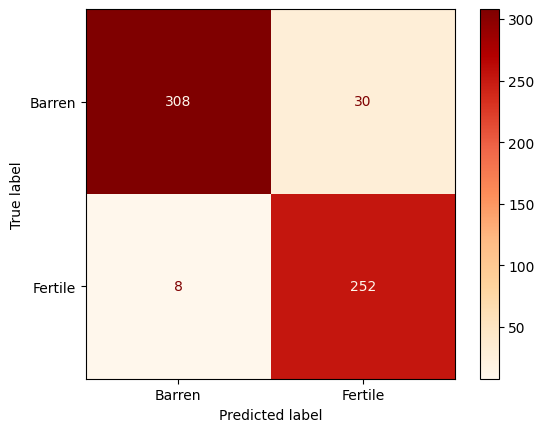

In [26]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot(cmap = 'OrRd')

### Plotting the decision boundary

In [27]:
input_features = X_test_scaled.copy()
output_feature = y_test.copy()

In [28]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(input_features)

In [29]:
X_reduced.shape

(598, 2)

In [30]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [31]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [32]:
plot_model = svm.SVC(**clf.best_params_)

plot_model.fit(X_reduced, output_feature)

SVC(C=4)

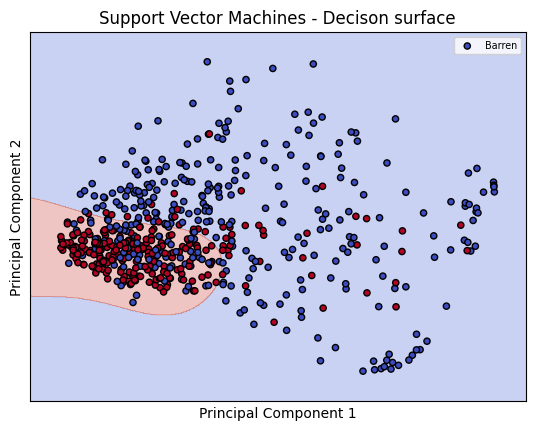

In [33]:
fig, ax = plt.subplots(facecolor='white')

# title for the plots
title = ('Decision surface of Tuned SVC ')

# Set-up grid for plotting.
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, plot_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3) # alpha=0.8
ax.scatter(X0, X1, c=y_test, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Support Vector Machines - Decison surface')
ax.legend(labels=['Barren', 'Fertile'], fontsize="x-small")
plt.show()

### Save the Best Performing Model

In [34]:
import pickle

with open('../Best model pickle files/svm_best.pkl', 'wb') as f:
    pickle.dump(best_model_gridsearch, f)

In [35]:
with open('../Best model pickle files/svm_best.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [36]:
clf_loaded

SVC(C=4)

[CV] END ..........C=0, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.2s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.2s
[CV] END ..........C=1, degree=3, gamma=auto, kernel=sigmoid; total time=   0.1s
[CV] END ..........C=1, degree=4, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..........C=1, degree=4, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..........C=1, degree=4, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..........C=1, degr

[CV] END ..........C=0, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..............C=0, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..............C=0, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=0, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=0, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=0, degree=4, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........C=0, degree=4, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...........C=0, deg

[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...........C=0, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=0, d

[CV] END ..........C=0, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=0, degree=4, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=0, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=0, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=0, degree=4, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, degree=4, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..........C=1, degree=4, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ............C=1, degree=4, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ............C=1, de

[CV] END ..........C=0, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .........C=0, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...........C=0, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............C=0, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..............C=0, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..............C=0, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=0, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0, degr